## Logistics

Name: Natalie Wang

Username: natalimw

** I have done the assignment in Jupyter notebook (so I have included the actual notebook in my file) but I have also included .py files for each section with the same code as in the Jupyter notebook for ease of testing.  For all code, you can run it by either running all cells in the jupyter notebook or running the .py files. **

In [226]:
## imports

import pandas as pd
import itertools
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import optimize
import random
import math
from IPython.display import IFrame

In [2]:
## read in data

cities = pd.read_csv('european_cities.csv', delimiter=';')
cities.index = list(cities)

## Exhaustive Search

The following code finds the shortest tour through exhaustive search.  It uses itertools.permutations to find all possible paths of the cities. For the first 6 cities, it takes ~0.012 seconds and it found the shortest path to be ('Barcelona', 'Belgrade', 'Bucharest', 'Budapest', 'Berlin', 'Brussels') with a distance of 5018.81. Refer to the dataframe below for additional cities.  For 10 cities it took my program ~25 seconds.  I fit these 5 points to an exponential function using scipy.optimize.  I got $y = 4.81063196e-09 * e^{2.2372584 * x} +  1.12413959e-02$ where x is the number of cities and y is the time it takes for the program to run.  Plugging in 24 cities; it would take 1002992554807504.4 seconds or more than 31 million years.  You can run the code by opening the ipython notebook and running all of the cells below.

In [3]:
pd.read_csv('exhaustive_search_city_overview.csv').drop('Unnamed: 0', axis=1)

,num_cities,time,tour,distance
0,6,0.012446,"('Barcelona', 'Belgrade', 'Bucharest', 'Budape...",5018.81
1,7,0.039712,"('Barcelona', 'Belgrade', 'Bucharest', 'Budape...",5487.89
2,8,0.301453,"('Barcelona', 'Belgrade', 'Bucharest', 'Budape...",6667.49
3,9,2.682424,"('Barcelona', 'Belgrade', 'Bucharest', 'Budape...",6678.55
4,10,25.043085,"('Barcelona', 'Belgrade', 'Istanbul', 'Buchare...",7486.31


In [4]:
tours = pd.DataFrame(columns=['num_cities', 'time', 'tour', 'distance'])

for i in range(6, 11):
    num_cities = i

    start_time = time.time()

    sub_cities = cities.iloc[0:num_cities,0:num_cities]
    possible_paths = [x for x in itertools.permutations(list(sub_cities))]

    min_path = -1
    min_dist = -1

    for path in possible_paths:
        ## only calculate paths starting from the same place to reduce redundancies
        if path[0] != 'Barcelona':
            break;
        
        ## calculate total distances
        dist = 0
        for city in range(len(path)-1):
            dist += sub_cities.loc[path[city], path[city+1]]
        dist += sub_cities.loc[path[-1], path[0]]

        ## only change min_path is distance is shortest or first distance to be calculated
        if min_dist > dist:
            min_path = path
            min_dist = dist

        elif min_dist == -1:
            min_path = path
            min_dist = dist


    runtime = time.time() - start_time

    tours = tours.append(pd.DataFrame([[num_cities, runtime, min_path, min_dist]], columns=['num_cities', 'time', 'tour', 'distance']))

## saving
tours.to_csv('exhaustive_search_city_overview.csv')

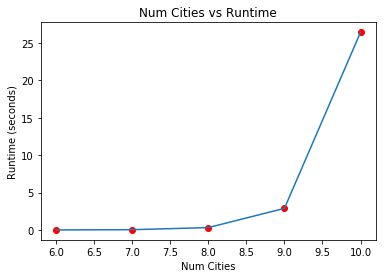

In [5]:
## experimental data
xdata = np.array([int(c) for c in tours['num_cities']])
ydata = np.array([float(t) for t in tours['time']])

## exponential function to fit
def func(x, a, b, c):
    return a * np.exp(b * x) + c

## fitting function
popt, pcov = scipy.optimize.curve_fit(func, xdata, ydata)

## plotting data
plt.plot(xdata, ydata, 'ro', label='data')
plt.plot(xdata, func(xdata, *popt))

plt.title('Num Cities vs Runtime')
plt.xlabel('Num Cities')
plt.ylabel('Runtime (seconds)')

plt.show()

In [6]:
## exponential equation coefficients

popt

array([6.40284262e-09, 2.21416714e+00, 9.60670973e-04])

In [7]:
## estimated time for 24 cities

func(24, *popt)

766984321546646.6

## Hill Climbing

The hill climber performs pretty comparably to exhaustive search; some of the runs result in the same path as exhaustive search.  Note, exact numbers may be slightly different when you run it.  For the first 10 cities, the length of the best tour was 7486.31, the length of the worst tour was 8346.94, the mean of the tours was 7600.89, and the SD of the runs was 259.47.  For all 24 cities, the length of the best tour was 12396.32, the length of the worst tour was 15422.99, the mean of the tours was 14350.001, and the SD of the runs was 747.38. You can run the code by opening the ipython notebook and running all of the cells below.

In [8]:
## returns the total length of a path

def path_dist(path):
    dist = 0
    for city in range(len(path) - 1):
        dist += cities.loc[path[city], path[city + 1]]
    dist += cities.loc[path[-1], path[0]]
    return dist

In [9]:
## creates random starting path 

def rand_start(city_list):
    path = city_list
    random.shuffle(path)
    return path

In [10]:
## finds neighbors (neighbors defined as swapping cities in path) and returns best neighboring path

def find_best_neighbor(path):
    curr_dist = path_dist(path)
    curr_path = path
    swappings = itertools.combinations(range(0, len(path)), 2)
    for swap in swappings:
        city_0 = path[swap[0]]
        city_1 = path[swap[1]]
        
        new_path = path.copy()
        new_path[swap[0]] = city_1
        new_path[swap[1]] = city_0
        
        new_dist = path_dist(new_path)
        
        ## if new path is shorter than curr path set curr path as new path and curr dist as new dist
        if new_dist < curr_dist:
            curr_path = new_path
            curr_dist = new_dist
    return curr_path

In [11]:
## implements hill climbing algorithm where neighbors count as current path switching 2 cities

def hill_climber(num_cities):
    subcities = cities.iloc[0:num_cities, 0:num_cities]
    path = rand_start(list(subcities))
    best_neighbor = find_best_neighbor(path)
    ##print(path, best_neighbor, path != best_neighbor)
    while (path != best_neighbor):
        path = best_neighbor
        #print(path_dist(path))
        best_neighbor = find_best_neighbor(path)
        #print(path_dist(best_neighbor))
    
    return path

In [12]:
## hill climbing for first 10 cities

best_path_distances = []

for i in range(20):    
    city_path = hill_climber(10)
    best_path_distances.append(path_dist(city_path))
    
print('best path distance: ', min(best_path_distances))
print('worst path distance: ', max(best_path_distances))
print('mean path distance: ', np.mean(best_path_distances))
print('SD of paths: ', np.std(best_path_distances))

best path distance:  7486.309999999999
worst path distance:  8407.18
mean path distance:  7573.457500000001
SD of paths:  210.61855414172334


In [13]:
## hill climbing for first 24 cities

best_path_distances = []

for i in range(20):    
    city_path = hill_climber(24)
    best_path_distances.append(path_dist(city_path))
    
print('best path distance: ', min(best_path_distances))
print('worst path distance: ', max(best_path_distances))
print('mean path distance: ', np.mean(best_path_distances))
print('SD of paths: ', np.std(best_path_distances))

best path distance:  12919.96
worst path distance:  17826.33
mean path distance:  14501.014500000001
SD of paths:  1169.4001548335584


## Genetic Algorithm

I have chosen 10, 25, and 50 as my population sizes.  Note: some number (like time per function run) may vary slightly due to this being a stochastic process.  Also all figures referred to below are saved as .csvs or .pdfs in the folder.


I have found  the following results for 20 runs of my GA for the first 10 cities:

|pop size|best path|worst path|mean path|SD|avg runtime|
|--------|---------|----------|---------|--|-----------|
|10|7549.16|8672.54|8207.72|253.789|1.43887|
|15|7486.31|7503.1|7489.67|6.716|1.91477|
|20|7486.31|7737.95|7509.56|59.455|1.89039|

See below for the figure of average fitness of the best fit individual in each generation.  It appears that 15 or 20 would be appropriate population sizes and num generations is < 100.

Among the first 10 cities, my GA found the shortest tour (as found by the exhaustive search) when the population size was 15 and 20 and offspring number was 10.  

My runtime for 10 cities with my GA was much faster (~4.6 seconds) compared to my runtime for 10 cities with exhaustive search (~23 seconds).  Performing my GA on 24 cities, our shortest path found was 12703.99.  My runtime for 24 cities with my GA was ~5.5 seconds which was much much faster than the estimated time for exhaustive search.  

For 10 cities, my GA (with population 15, offspring 10, and assuming 100 runs) compared 1500 tours (i.e. 15 * 100) while exhaustive search compared 181440 tours (i.e. $\frac{(n-1)!}{2}$).  For 24, GA (with population 15, offspring 10, and assuming 100 runs) = 1500 tours, Exhaustive Search = 1.292600836944249e+22 tours.

Directly under this cell, I have put all relevant data frames I have created for this problem.  To create them again, simply run the cells below (after running the import statements at the beginning and loading in data.

In [253]:
##NOTE: RUN EACH LINE IN DIFFERENT CELL TO VIEW

## 10 City GA - best, worst, mean, SD, avg time
pd.read_csv('10_city_GA.csv')

## 10 City Avg Path Dist for Each Run for Each Population
pd.read_csv('10_city_GA_runs.csv')

## 10 city graph
IFrame("avg_path_10_cities.pdf", 700, 500)

In [257]:
##NOTE: RUN EACH LINE IN DIFFERENT CELL TO VIEW

## 24 City GA - best, worst, mean, SD, avg time
pd.read_csv('24_city_GA.csv')

## 24 City Avg Path Dist for Each Run for Each Population
pd.read_csv('24_city_GA_runs.csv')

## 24 city graph
IFrame("avg_path_24_cities.pdf", 700, 500)

In [14]:
## creates random starting path 

def rand_start(city_list):
    path = city_list
    random.shuffle(path)
    return path

In [15]:
## initialize a random population to start

def rand_pop(num_cities, pop_size):
    subcities = cities.iloc[0:num_cities, 0:num_cities]
    
    pos_cities = list(subcities)
    
    pop = []
    
    for i in range(pop_size):
        r = rand_start(pos_cities)
        pop.append(r.copy())
        
    return pop

In [16]:
## returns the total length of a path

def path_dist(path):
    dist = 0
    for city in range(len(path) - 1):
        dist += cities.loc[path[city], path[city + 1]]
    dist += cities.loc[path[-1], path[0]]
    return dist

In [101]:
## select parents as shortest routes

def select_parents(pop, num_offspring):
    path_lens = {}
    
    for path in pop:
        dist = path_dist(path)
        while dist in path_lens.keys():
            dist += .001
        
        path_lens[dist] = path
    p_keys = list(path_lens.keys())
    p_keys.sort()
    parents = p_keys[0:num_offspring*2]
    return [path_lens[p] for p in parents]

In [18]:
## make offspring form 2 parents

def make_offspring(parents, rand_seg):
    p1 = parents[0]
    p2 = parents[1]
    
    poss_starts = range(len(p1) - rand_seg)
    start = random.sample(poss_starts, 1)[0]
    
    offspring = list(np.zeros(len(p1)))
    
    ## copy randomly selected set from first parent
    for i in range(rand_seg):
        offspring[start+i] = p1[start+i]
        
    ## copy rest from second parent order
    s_order = list(p2[start+rand_seg::] + p2[0:start+rand_seg])
    
    for city in range(len(offspring)):
        if offspring[city] == 0:
            for elm in s_order:
                if elm not in offspring:
                    offspring[city] = elm
                    break;
                    
    return offspring
    

In [19]:
## make new population

def make_new(pop, num_offspring):
    ## choose parents
    parents = select_parents(pop, num_offspring)
    pos_pairs = random.sample([x for x in itertools.combinations(range(len(parents)), 2)], num_offspring)
    
    ## make offspring
    kids = []
    
    for pair in pos_pairs:
        offspring = make_offspring([parents[pair[0]], parents[pair[1]]], num_offspring//2)
        kids.append(offspring)
        
    return kids

In [20]:
## see how population performs

def performance(population):
    performance = []
    for i in population:
        performance.append(path_dist(i))
    return min(performance)

In [194]:
## perform genetic algo

def genetic_algo(num_cities, pop_size, num_offspring):
    
    ## create randomized starting population
    init_pop = rand_pop(num_cities, pop_size)
    
    ## select parent group
    parents = select_parents(init_pop, num_offspring)
    
    ## make kids from parents
    kids = make_new(parents, num_offspring)

    ## best kids for each run
    best_kid = [performance(init_pop)]
    
    i = 1500
    ## make sure the algo runs at least 100 generations but no more than 1500
    while (performance(parents) != performance(kids) and i > 1  or i > 1400):
        i -= 1
        if pop_size > num_offspring:
            start = time.time()
            parents = select_parents(kids + parents, num_offspring)
            kids = make_new(parents, num_offspring)
            best_kid.append(performance(kids))
        elif pop_size == num_offspring:
            parents = kids
            kids = make_new(parents, num_offspring)
            best_kid.append(performance(kids))
        else:
            parents = select_parents(kids, num_offspring)
            kids = make_new(parents, num_offspring)
            best_kid.append(performance(kids))
            
    return best_kid

In [195]:
## example using GA on 6 cities

start = time.time()
gens = genetic_algo(6, 10, 5)
t = time.time() - start
print('best path: ', min(gens))
print('num gens: ', len(gens))
print('total time: ', t)

best path:  5018.8099999999995
num gens:  101
total time:  0.19656801223754883


In [197]:
## example using GA on 10 cities

start = time.time()
gens = genetic_algo(10, 10, 5)
t = time.time() - start
print('best path: ', min(gens))
print('num gens: ', len(gens))
print('total time: ', t)

best path:  7486.3099999999995
num gens:  1500
total time:  4.631490230560303


In [213]:
## example using GA on 24 cities

start = time.time()
gens = genetic_algo(24, 20, 10)
t = time.time() - start
print('best path: ', min(gens))
print('num gens: ', len(gens))
print('total time: ', t)

best path:  13702.89
num gens:  354
total time:  5.506443023681641


In [254]:
## perform GA for given number of cities and create associated data tables and plots

def perform_GA(num_cities):
    pop_sizes = [10, 15, 20]
    
    tens = []
    tens_time = []
    ten_runs = pd.DataFrame(columns = range(100))

    one_hundred = []
    one_hundred_time = []
    one_hundred_runs = pd.DataFrame(columns = range(100))

    two_hundred = []
    two_hundred_time = []
    two_hundred_runs = pd.DataFrame(columns = range(100))
    
    for i in range(20):
        for p in pop_sizes:
            if p == 10:
                start_time = time.time()
                g = genetic_algo(num_cities, p, 10)
                tens.append(min(g))
                tens_time.append(time.time() - start_time)
                ten_runs.loc[i,:] = g[0:100]
                
            elif p == 15:
                start_time = time.time()
                g = genetic_algo(num_cities, p, 10)
                one_hundred.append(min(g))
                one_hundred_time.append(time.time() - start_time)
                one_hundred_runs.loc[i,:] = g[0:100]
                
            else:
                start_time = time.time()
                g = genetic_algo(num_cities, p, 10)
                two_hundred.append(min(g))
                two_hundred_time.append(time.time() - start_time)
                two_hundred_runs.loc[i,:] = g[0:100]
                
    
    stats = pd.DataFrame(columns=['best path', 'worst path', 'mean path', 'SD', 'avg runtime'])
    run_stats = pd.DataFrame(columns=list(range(len(ten_runs))))

    results = [tens, one_hundred, two_hundred]
    times = [tens_time, one_hundred_time, two_hundred_time]
    runs = [ten_runs, one_hundred_runs, two_hundred_runs]

    for i in range(len(pop_sizes)):
        stats.loc[pop_sizes[i], 'best path'] = min(results[i])
        stats.loc[pop_sizes[i], 'worst path'] = max(results[i])
        stats.loc[pop_sizes[i], 'mean path'] = np.mean(results[i])
        stats.loc[pop_sizes[i], 'SD'] = np.std(results[i])
        stats.loc[pop_sizes[i], 'avg runtime'] = np.mean(times[i])

        for j in range(100):
            run_stats.loc[pop_sizes[i], j] = np.mean(runs[i][j])

    ## saving
    stats.to_csv(str(num_cities) + '_city_GA.csv')
    run_stats.to_csv(str(num_cities) + '_city_GA_runs.csv')
    
    ## plotting avg best performing run for each pop size
    f = run_stats.T.plot()
    plt.title('Avg Path Distance for ' + str(num_cities) + ' Cities')
    plt.xlabel('Run #')
    plt.ylabel('Distance')
    plt.legend(title='pop size', fancybox=True)
    plt.show()
    fig = f.get_figure()
    fig.savefig('avg_path_' + str(num_cities) + '_cities.pdf', bbox_inches='tight')
    
    return min(min(tens), min(one_hundred), min(two_hundred))

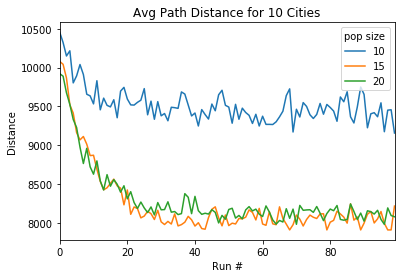

7486.3099999999995

In [222]:
perform_GA(10)

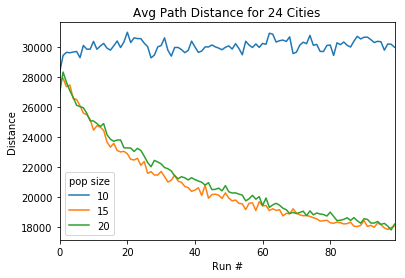

12703.99

In [256]:
perform_GA(24)